In [1]:
import json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statannotations.Annotator import Annotator


In [2]:
def cv_evaluate(features: pd.DataFrame, labels: pd.DataFrame, params: dict, scoring="roc_auc", random_state=1):
    n_repeats = 5
    n_splits = 5
    n_jobs = -1

    rkf = RepeatedStratifiedKFold(n_repeats=n_repeats, n_splits=n_splits, random_state=random_state)

    pipe = Pipeline(
        [('var_thresh', VarianceThreshold()),
         ('scaler', StandardScaler()),
         ('imputer', KNNImputer()),
         ('sampler', RandomUnderSampler(random_state=random_state)),
         ('clf', BalancedRandomForestClassifier(random_state=random_state, n_jobs=n_jobs, sampling_strategy='all',
                                                replacement=True))])

    pipe.set_params(**params)

    X, X_test, y, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, stratify=labels,
                                            random_state=random_state)

    rs_result = cross_validate(pipe, X, y, cv=rkf, scoring=scoring, n_jobs=n_jobs)
    rs_results_cv = pd.DataFrame(rs_result)

    model = pipe.fit(X, y)

    return rs_results_cv, model, X, y, X_test, y_test


network_type = 'large'
target_db = 'DRH'

scoring = 'roc_auc'
random_state = 231222


In [3]:
original = pd.read_csv(f'../../2_feature_extraction/{network_type}/features_{target_db} Target.csv', index_col=0)
original = original.drop(['Target', 'Neighbor'], axis=1)
original = original[original['Outcome'] != 'Very Weak']
original = original[original['Outcome'] != 'Low']
original['Outcome'] = original['Outcome'].replace({'Weak': 'Effect'})
original['Outcome'] = original['Outcome'].replace({'Strong': 'Effect'})
original['Outcome'] = original['Outcome'].replace({'No-Effect': 0, 'Cyto': -1, 'Effect': 1})
outcomes = ['No-Effect vs. Effect', 'No-Effect vs. Cyto', 'Cyto vs. Effect']
results = {}
results_random = {}
for outcome in outcomes:
    print(" " + outcome)
    data = original.copy()
    os = outcome.split(' vs. ')
    drop_outcome = None
    if 'Effect' not in os:
        drop_outcome = 1
        data = data[data['Outcome'] != drop_outcome]
        data['Outcome'] = data['Outcome'].replace({-1: 1})
    elif 'Cyto' not in os:
        drop_outcome = -1
        data = data[data['Outcome'] != drop_outcome]
    elif 'No-Effect' not in os:
        drop_outcome = 0
        data = data[data['Outcome'] != drop_outcome]
        data['Outcome'] = data['Outcome'].replace({-1: 0})
    else:
        raise Exception()

    data = data.dropna()
    labels = data.copy().loc[:, 'Outcome']
    features = data.copy().drop('Outcome', axis=1)
    with open(f'../../4_hyperparameter_search/{network_type}/{outcome.replace("_", "-").replace(" vs. ", "_")}.json',
              'r') as file:
        real_params = json.load(file)
    with open(
            f'../../4_hyperparameter_search/{network_type}/{outcome.replace("_", "-").replace(" vs. ", "_")}_rand.json',
            'r') as file:
        rand_params = json.load(file)

    cv_result, model, X_train, y_train, X_test, y_test = cv_evaluate(features=features, labels=labels,
                                                                     params=real_params, scoring=scoring)
    results[outcome] = {'cv_evaluation': cv_result, 'model': model, 'X_train': X_train, 'y_train': y_train,
                        'X_test': X_test, 'y_test': y_test}
    y_pred = model.predict(X_test)
    
    rand_cv_results = []
    for i in range(1, 101):
        random_state += 1
        cv_result, _, _, _, _, _ = cv_evaluate(features, labels.sample(frac=1.0, random_state=random_state), params=rand_params, scoring=scoring)
        rand_cv_results.append(cv_result)
    results_random[outcome] = {'cv_evaluation': rand_cv_results, 'model': None}
    #rand_y_pred = rand_model.predict(rand_X_test)

target_results = {'real': results, 'random': results_random}
joblib.dump(target_results, f'results_new.sav')

 No-Effect vs. Effect
 No-Effect vs. Cyto
 Cyto vs. Effect


['results_new.sav']

,score,model,labels,metric
0,0.751767,No-Effect vs. Effect,real,roc_auc
1,0.739690,No-Effect vs. Effect,real,roc_auc
2,0.695208,No-Effect vs. Effect,real,roc_auc
3,0.671569,No-Effect vs. Effect,real,roc_auc
4,0.683178,No-Effect vs. Effect,real,roc_auc
...,...,...,...,...
21,0.489602,Cyto vs. Effect,random,roc_auc
22,0.472859,Cyto vs. Effect,random,roc_auc
23,0.533264,Cyto vs. Effect,random,roc_auc
24,0.509900,Cyto vs. Effect,random,roc_auc


Welch's t-test independent samples, P_val:1.144e-15 t=1.558e+01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


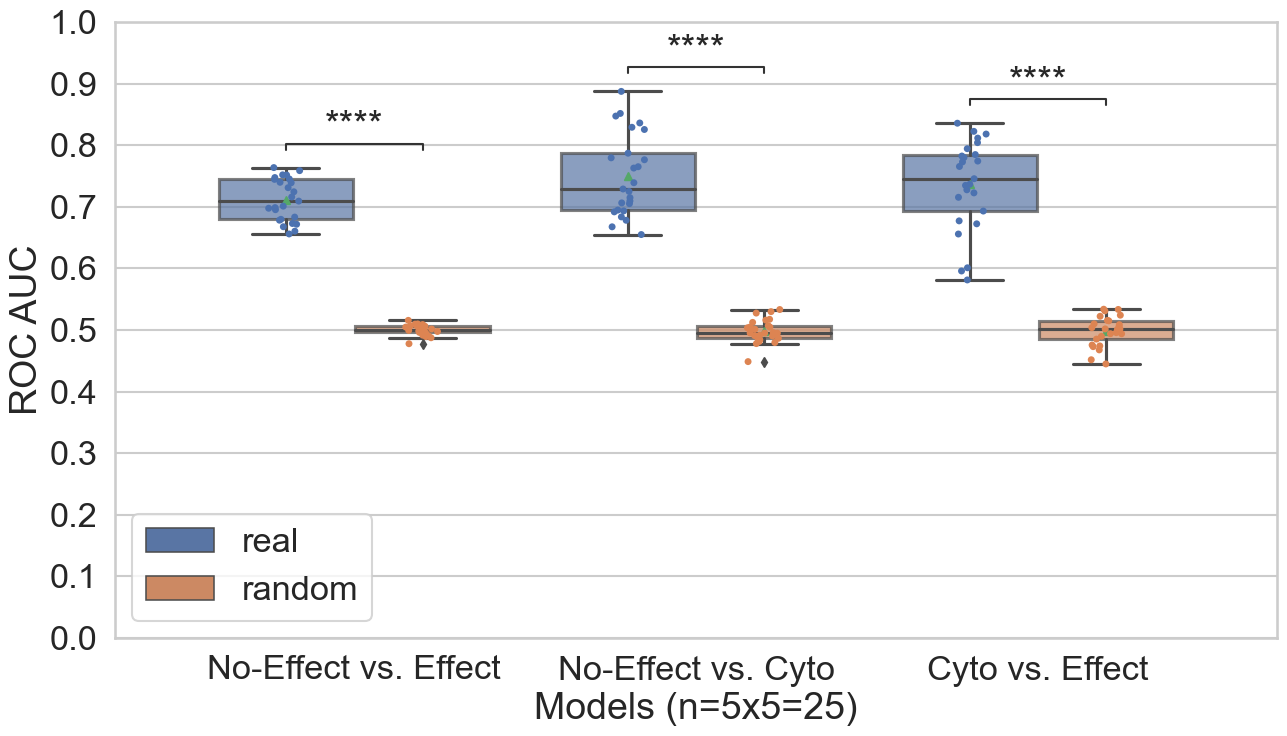

In [23]:
target_results = joblib.load(f'results_new.sav')
model_evaluations = []

results = target_results['real']
for key in results.keys():
    result = results[key]['cv_evaluation'].loc[:, 'test_score'].to_frame()
    result['model'] = key
    result['labels'] = 'real'
    result['metric'] = scoring
    result.columns = ['score', 'model', 'labels', 'metric']
    model_evaluations.append(result)
    
results_random = target_results['random']
for key in results.keys():
    result_random = results_random[key]['cv_evaluation']
    result_random = pd.concat(result_random).reset_index()
    result_random = result_random.loc[:, 'test_score'].to_frame()
    result_random['fold'] = (result_random.index // 100) + 1
    result_random = result_random.groupby('fold').mean()
    result_random['model'] = key
    result_random['labels'] = 'random'
    result_random['metric'] = scoring
    result_random.columns = ['score', 'model', 'labels', 'metric']
    model_evaluations.append(result_random)
    
scores = pd.concat(model_evaluations)
display(scores)

sns.set("talk", font_scale=1.5)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=100)
sns.boxplot(data=scores, x='model', y='score', hue='labels', showmeans=True, ax=ax, boxprops=dict(alpha=.7))
sns.stripplot(data=scores, x='model', y='score', hue='labels', ax=ax, dodge=True, jitter=True, alpha=1.0)
pairs = [(('No-Effect vs. Cyto', 'real'), ('No-Effect vs. Cyto', 'random')),
         (('No-Effect vs. Effect', 'real'), ('No-Effect vs. Effect', 'random')),
         (('Cyto vs. Effect', 'real'), ('Cyto vs. Effect', 'random'))]
annotator = Annotator(ax, pairs, data=scores, x="model", y="score", hue="labels")
annotator.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0, text_offset=0,
                    line_offset=0.0)
annotator.apply_and_annotate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
ax.set(ylabel='ROC AUC')
ax.set(xlabel='Models (n=5x5=25)')
ax.set(yticks=np.arange(0.0, 1.1, step=0.1))
fig.savefig(f'cv_evaluation.png', format="png", dpi=300)
fig.savefig(f'cv_evaluation.eps', format="eps", dpi=300)
fig.savefig(f'cv_evaluation.pdf', format="pdf", dpi=300)
fig.savefig(f'cv_evaluation.svg', format="svg", dpi=300)

,score,model,labels,metric
0,0.751767,No-Effect vs. Effect,real,roc_auc
1,0.739690,No-Effect vs. Effect,real,roc_auc
2,0.695208,No-Effect vs. Effect,real,roc_auc
3,0.671569,No-Effect vs. Effect,real,roc_auc
4,0.683178,No-Effect vs. Effect,real,roc_auc
...,...,...,...,...
2495,0.515351,Cyto vs. Effect,random,roc_auc
2496,0.434211,Cyto vs. Effect,random,roc_auc
2497,0.405405,Cyto vs. Effect,random,roc_auc
2498,0.576555,Cyto vs. Effect,random,roc_auc


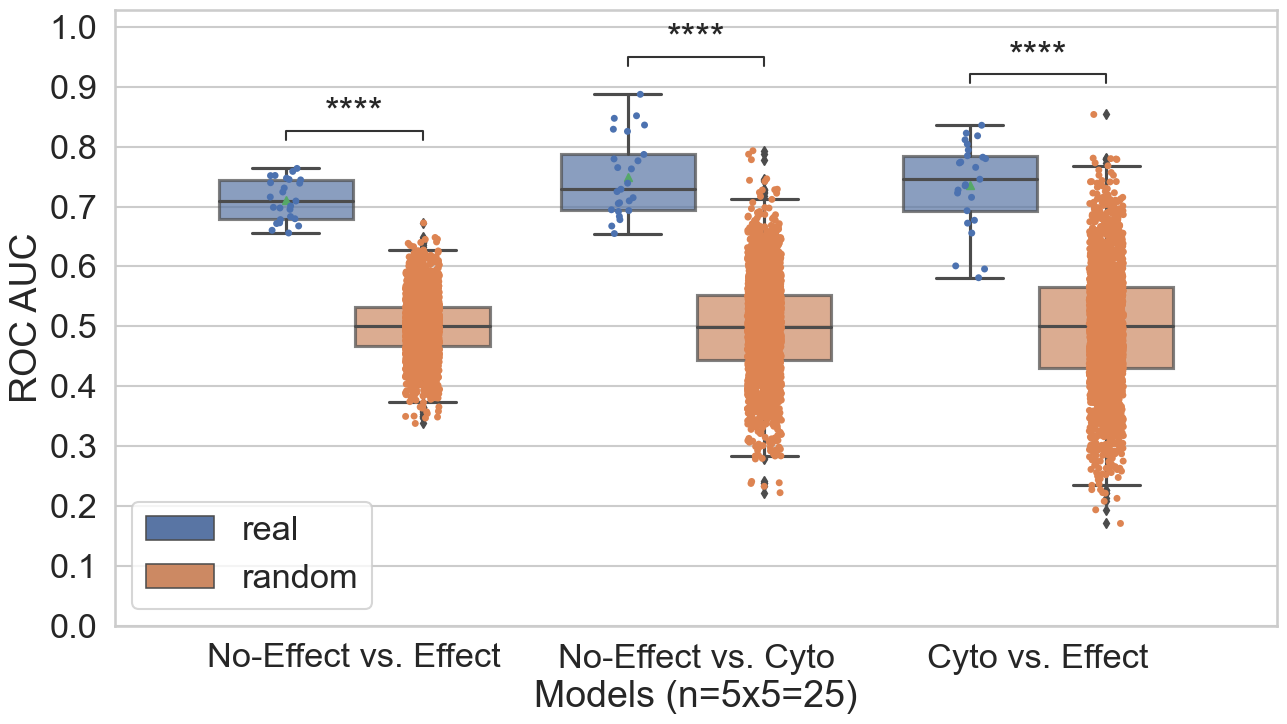

In [18]:
target_results = joblib.load(f'results_new.sav')
model_evaluations = []

results = target_results['real']
for key in results.keys():
    result = results[key]['cv_evaluation'].loc[:, 'test_score'].to_frame()
    result['model'] = key
    result['labels'] = 'real'
    result['metric'] = scoring
    result.columns = ['score', 'model', 'labels', 'metric']
    model_evaluations.append(result)
    
results_random = target_results['random']
for key in results.keys():
    result_random = results_random[key]['cv_evaluation']
    result_random = pd.concat(result_random).reset_index()
    result_random = result_random.loc[:, 'test_score'].to_frame()
    result_random['model'] = key
    result_random['labels'] = 'random'
    result_random['metric'] = scoring
    result_random.columns = ['score', 'model', 'labels', 'metric']
    model_evaluations.append(result_random)
    
scores = pd.concat(model_evaluations)
display(scores)

sns.set("talk", font_scale=1.5)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(15, 8), dpi=100)
sns.boxplot(data=scores, x='model', y='score', hue='labels', showmeans=True, ax=ax, boxprops=dict(alpha=.7))
sns.stripplot(data=scores, x='model', y='score', hue='labels', ax=ax, dodge=True, jitter=True, alpha=1.0)
pairs = [(('No-Effect vs. Cyto', 'real'), ('No-Effect vs. Cyto', 'random')),
         (('No-Effect vs. Effect', 'real'), ('No-Effect vs. Effect', 'random')),
         (('Cyto vs. Effect', 'real'), ('Cyto vs. Effect', 'random'))]
annotator = Annotator(ax, pairs, data=scores, x="model", y="score", hue="labels")
annotator.configure(test='t-test_welch', text_format='star', loc='inside', verbose=0, text_offset=0,
                    line_offset=0.0)
annotator.apply_and_annotate()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
ax.set(ylabel='ROC AUC')
ax.set(xlabel='Models (n=5x5=25)')
ax.set(yticks=np.arange(0.0, 1.1, step=0.1))
fig.savefig(f'cv_evaluation_all_dots.png', format="png", dpi=300)
fig.savefig(f'cv_evaluation_all_dots.pdf', format="pdf", dpi=300)

In [77]:
from scipy import stats

target_results = joblib.load(f'results_new.sav')
model_evaluations = []

results = target_results['real']
for key in results.keys():
    result = results[key]['cv_evaluation'].loc[:, 'test_score'].to_frame()
    result['model'] = key
    result['labels'] = 'real'
    result['metric'] = scoring
    result.columns = ['score', 'model', 'labels', 'metric']
    model_evaluations.append(result)
    
results_random = target_results['random']
perm = 0
for key in results.keys():
    result_random = results_random[key]['cv_evaluation']
    result_random = pd.concat(result_random).reset_index()
    result_random = result_random.loc[:, 'test_score'].to_frame()
    result_random['model'] = key
    result_random['labels'] = 'random'
    result_random['metric'] = scoring
    result_random.columns = ['score', 'model', 'labels', 'metric']
    model_evaluations.append(result_random)
    
scores = pd.concat(model_evaluations)
display(scores)
real_df = scores.loc[scores['labels'] == 'real', :]
rand_df = scores.loc[scores['labels'] == 'random', :]

pvalues = []
for model in real_df['model'].unique():
    real = real_df.loc[real_df['model'] == model, 'score']
    rand = rand_df.loc[rand_df['model'] == model, 'score']
    
    from_idx = 0
    to_idx = 25
    for i in range(100):
        pvalues.append([model, stats.ttest_ind(real, rand.iloc[from_idx:to_idx], equal_var=False).pvalue])
        from_idx = to_idx
        to_idx += 25
    
df = pd.DataFrame(pvalues, columns=['model', 'pvalue'])
df['bonferroni'] = df['pvalue'].apply(lambda x: x * 100)
df['sign'] = df['pvalue'].apply(lambda x: 'no' if x > 0.05 else 'yes')
df['sign_bonferroni'] = df['bonferroni'].apply(lambda x: 'no' if x > 0.05 else 'yes')
df = df.reset_index(names='permutation_no')
df.to_csv('pvalues.csv', index=False)


,score,model,labels,metric
0,0.751767,No-Effect vs. Effect,real,roc_auc
1,0.739690,No-Effect vs. Effect,real,roc_auc
2,0.695208,No-Effect vs. Effect,real,roc_auc
3,0.671569,No-Effect vs. Effect,real,roc_auc
4,0.683178,No-Effect vs. Effect,real,roc_auc
...,...,...,...,...
2495,0.515351,Cyto vs. Effect,random,roc_auc
2496,0.434211,Cyto vs. Effect,random,roc_auc
2497,0.405405,Cyto vs. Effect,random,roc_auc
2498,0.576555,Cyto vs. Effect,random,roc_auc


In [78]:
df

,permutation_no,model,pvalue,bonferroni,sign,sign_bonferroni
0,0,No-Effect vs. Effect,3.264351e-23,3.264351e-21,yes,yes
1,1,No-Effect vs. Effect,2.152790e-18,2.152790e-16,yes,yes
2,2,No-Effect vs. Effect,4.448756e-21,4.448756e-19,yes,yes
3,3,No-Effect vs. Effect,6.219533e-22,6.219533e-20,yes,yes
4,4,No-Effect vs. Effect,3.417773e-19,3.417773e-17,yes,yes
...,...,...,...,...,...,...
295,295,Cyto vs. Effect,3.966280e-09,3.966280e-07,yes,yes
296,296,Cyto vs. Effect,1.208672e-16,1.208672e-14,yes,yes
297,297,Cyto vs. Effect,1.113122e-14,1.113122e-12,yes,yes
298,298,Cyto vs. Effect,4.559182e-14,4.559182e-12,yes,yes
